In [24]:
# Imports
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import ipywidgets as widgets
from IPython.display import display

# 📂 Carga del dataset en el entorno de Google Colab
Este bloque permite al usuario subir manualmente un archivo CSV desde su computadora a **Google Colab**. Al ejecutarlo, se abre una ventana de carga de archivos y, una vez seleccionado el archivo, se lee utilizando **pandas** y se almacena en un **DataFrame** llamado **df**. La función **df.head()** muestra las primeras filas del dataset para verificar que la carga fue exitosa y visualizar su estructura inicial.

In [25]:
# ======================
# 📁 Step 2: Upload Dataset
# ======================

dataset = './documents/ratings_Electronics (1).csv'
if os.path.exists(dataset):
    print(f"Dataset found at {dataset}")
else:
    print(f"Dataset not found at {dataset}. Please upload the dataset.")


# Replace the name below with your actual file name
df = pd.read_csv(dataset, names=['userId', 'productId', 'rating', 'timestamp'], header=0)

# Display the first few rows of the DataFrame to verify the data
print("Dataset loaded successfully!")
df.head()


Dataset found at ./documents/ratings_Electronics (1).csv
Dataset loaded successfully!


,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


# 🧹 Preprocesamiento del dataset: filtrado de reseñas y limpieza
Este bloque carga nuevamente el archivo CSV, esta vez sin encabezados, asignando manualmente los nombres de las columnas **(user_id, product_id, rating, value)** para estructurar adecuadamente el **DataFrame**. Luego, filtra las reseñas para conservar únicamente aquellas con una calificación perfecta **(5 estrellas)**, lo cual permite enfocarse en recomendaciones positivas y de alta calidad. Posteriormente, se eliminan las columnas innecesarias, quedándose solo con las relaciones **usuario-producto**. También se eliminan posibles filas con valores **nulos** y se configura **pandas** para mostrar toda la información del DataFrame sin truncamientos, facilitando su análisis visual completo.

In [26]:
# ======================
# 🔍 Step 3: Preprocess Dataset
# ======================
# Keep only 5-star reviews
df = df[df['rating'] == 5.0]

# Keep only relevant columns
df = df[['userId', 'productId']]
df.dropna(inplace=True)

# Optional: reduce size for speed
# df = df.sample(10000)

# Show all rows and columns in the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 🧱 Construcción del grafo bipartito a partir del dataset de Amazon Reviews
Este bloque construye un grafo bipartito utilizando la librería **networkx**, donde los nodos representan **usuarios** y **productos**, y las **aristas** reflejan las interacciones entre ellos **(reseñas de 5 estrellas)**. Los usuarios se añaden como un grupo de nodos **(bipartite=0)** y los productos como otro **(bipartite=1)**. Las conexiones entre ambos grupos se generan a partir de las relaciones presentes en el **DataFrame**. Finalmente, en lugar de mostrar solo un conteo básico, se crea una tabla resumen que visualiza de forma clara y ordenada el número total de nodos, usuarios, productos y enlaces dentro del grafo, ofreciendo una visión general del tamaño y densidad de la red.

In [27]:
# ======================
# 🧱 Step 4: Build Bipartite Graph
# ======================
B = nx.Graph()

# Add user and product nodes
B.add_nodes_from(df['userId'].unique(), bipartite=0)
B.add_nodes_from(df['productId'].unique(), bipartite=1)

# Add edges from user-product interactions
edges = list(df.itertuples(index=False, name=None))
B.add_edges_from(edges)

print(f"Bipartite Graph — Nodes: {len(B.nodes())}, Edges: {len(B.edges())}")


Bipartite Graph — Nodes: 2955802, Edges: 4347540


# 🔁 Proyección del grafo bipartito a un grafo unipartito de productos
En esta etapa, se toma el **grafo bipartito** construido previamente y se proyecta exclusivamente sobre el conjunto de productos. Esto genera un nuevo grafo en el que cada nodo representa un producto, y las aristas indican que dichos productos fueron calificados por al menos un usuario en común. La proyección utiliza pesos en las aristas para reflejar cuántos usuarios compartieron esas calificaciones, lo que permite medir la similitud entre productos. Finalmente, se muestra una tabla resumen que indica el número total de productos conectados en esta nueva red y el total de relaciones encontradas, proporcionando una vista clara y concisa del tamaño del grafo resultante.

In [28]:
# ======================
# 🔁 Step 5: Project to Product Graph
# ======================
# Get product nodes (bipartite=1)
product_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}

# Project onto product nodes
P = bipartite.weighted_projected_graph(B, product_nodes)

print(f"Projected Product Graph — Nodes: {len(P.nodes())}, Edges: {len(P.edges())}")

Projected Product Graph — Nodes: 358457, Edges: 7185545


In [29]:
# prompt: Print the first 100 product_list
product_list = list(P.nodes())
print(product_list[:2])

['B0079RY5AI', 'B000P6R45S']


# 🎯 Generación y visualización de recomendaciones personalizadas
Este bloque implementa la lógica del sistema de recomendación junto con una presentación visual amigable. La función recommend_products toma un product_id como entrada y busca en el grafo proyectado los productos más similares, basándose en la cantidad de usuarios que calificaron ambos. Ordena estas conexiones por su peso (usuarios en común), selecciona los productos con mayor similitud y limita el número de recomendaciones para mantener la salida manejable. La función complementaria show_recommendations_table convierte esta lista en una tabla con pandas, mostrando los productos recomendados junto con su peso, lo que facilita la interpretación de las sugerencias generadas por el sistema. Esta estructura permite ofrecer recomendaciones precisas y fácilmente visualizables para cualquier producto dentro del grafo.

In [30]:
# ======================
# 💡 Step 6: Recommendation Function
# ======================

def recommend_products(product_id, n=4, max_products=10):
    if product_id not in P:
        return "Product not found in network."

    # Get neighbors and their weights (connections between products)
    neighbors = [(neighbor, data["weight"]) for neighbor, data in P[product_id].items()]

    # Sort by weight (highest first)
    neighbors.sort(key=lambda x: x[1], reverse=True)

    # Get the top N unique weights
    unique_weights = sorted(set(weight for _, weight in neighbors), reverse=True)
    top_n_weights = unique_weights[:n]  # Select the highest N weights

    # Filter to include all products with these top weights
    filtered_neighbors = [(prod, weight) for prod, weight in neighbors if weight in top_n_weights]

    # Limit the number of displayed products to `max_products`
    filtered_neighbors = filtered_neighbors[:max_products]

    return filtered_neighbors


# 🌐 Visualización interactiva del sistema de recomendación con red tipo estrella
Este bloque combina visualización y usabilidad para presentar las recomendaciones de forma clara e interactiva. La función **plot_recommendations** genera una red tipo estrella, colocando el producto seleccionado en el centro y conectándolo con sus vecinos recomendados, donde el grosor de las aristas representa la fuerza de la relación **(usuarios en común)**, y los cuatro productos más similares se destacan en rojo. A su vez, se implementan widgets interactivos mediante **ipywidgets** que permiten al usuario seleccionar un producto y definir cuántas recomendaciones desea visualizar **(Top N)**. Al hacer clic en el botón, se despliega una lista con los productos recomendados y sus pesos, junto con la gráfica centrada en el producto elegido.

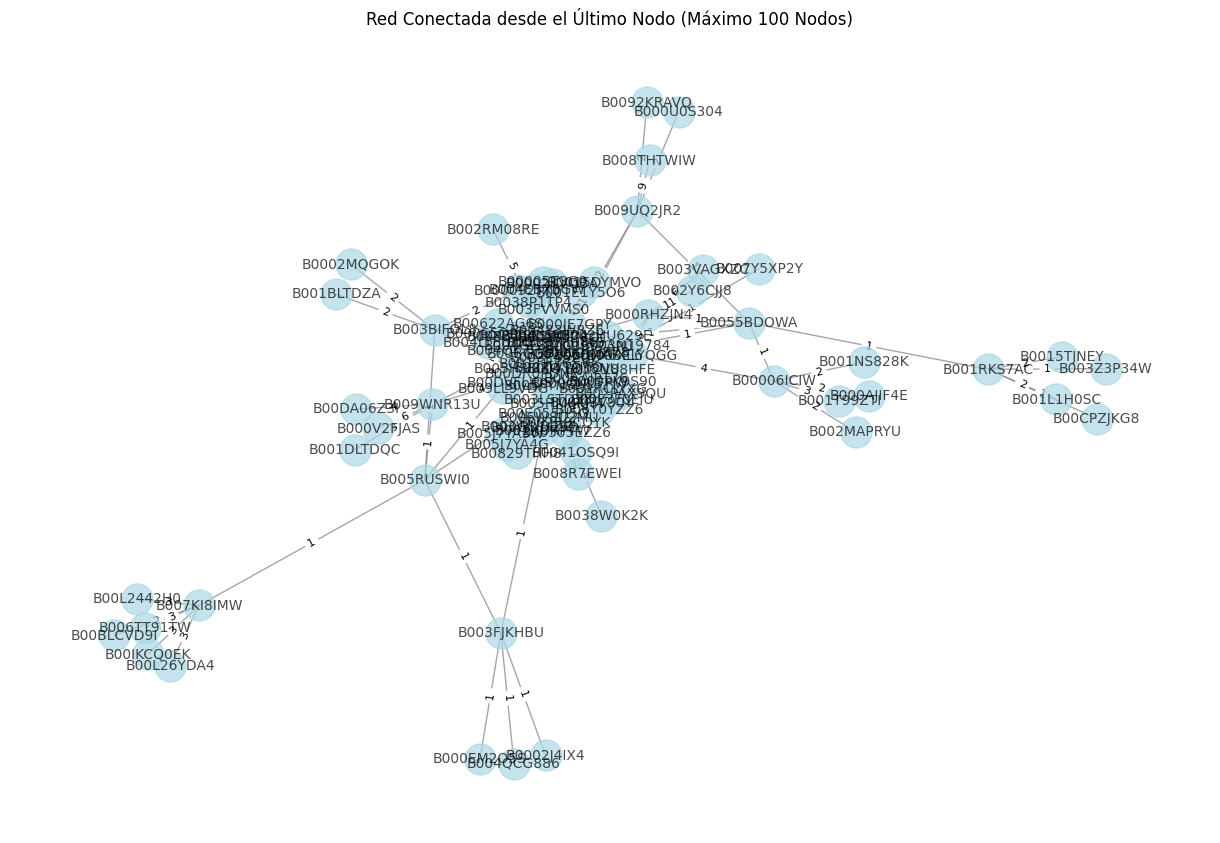

In [38]:
# ======================
# 🌟 Visualización de una red conectada desde el último nodo con hasta 50 conexiones
# ======================

# Seleccionar el último nodo del grafo proyectado
last_node = list(P.nodes())[-1]  # Último nodo
subgraph = nx.Graph()
visited_nodes = set()  # Para evitar duplicados
queue = [last_node]  # Cola para explorar nodos
max_nodes = 100  # Límite de nodos en la red

# Construir el subgrafo conectando nodos y vecinos relevantes
while queue and len(subgraph.nodes) < max_nodes:
    node = queue.pop(0)
    if node not in visited_nodes:
        visited_nodes.add(node)
        if node in P:
            # Obtener los vecinos más relevantes (máximo 5 conexiones por nodo)
            neighbors = sorted(P[node].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]
            subgraph.add_node(node)  # Agregar el nodo principal
            for neighbor, data in neighbors:
                subgraph.add_node(neighbor)  # Agregar el vecino
                subgraph.add_edge(node, neighbor, weight=data['weight'])  # Conectar el nodo con su vecino
                if len(subgraph.nodes) < max_nodes and neighbor not in visited_nodes:
                    queue.append(neighbor)  # Agregar el vecino a la cola para explorarlo

# Dibujar el subgrafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)  # Layout para una mejor visualización
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    font_size=10,
    edge_color="gray",
    alpha=0.7
)

# Añadir etiquetas de peso a las aristas
edge_labels = nx.get_edge_attributes(subgraph, "weight")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Red Conectada desde el Último Nodo (Máximo 100 Nodos)")
plt.show()

In [32]:
# ======================
# 🔘 Step 7: Plot Star Network with Top N Neighbors and Edge Weights
# ======================
def plot_recommendations(product_id, recommendations, max_products=10):
    # Create a new graph for visualization
    G = nx.Graph()

    # Add the central node (selected product)
    G.add_node(product_id)

    # Sort recommendations based on weight
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Add nodes and edges for the top max_products neighbors
    for i, (neighbor, weight) in enumerate(recommendations[:max_products]):
        G.add_node(neighbor)
        G.add_edge(product_id, neighbor, weight=weight)

    # Get the top 4 recommendations (based on the highest weights)
    top_4_neighbors = recommendations[:4]

    # Define edge colors and thickness based on weight
    edge_colors = ['red' if (prod, weight) in top_4_neighbors else 'gray' for prod, weight in recommendations[:max_products]]
    edge_widths = [weight / max([w for _, w in recommendations]) * 5 for _, weight in recommendations[:max_products]]  # Scale width based on max weight

    # Draw the network with the central node in the middle
    pos = nx.circular_layout(G)  # Arrange nodes in a circle
    pos[product_id] = (0, 0)  # Place the central node (product) in the center

    # Draw nodes and labels
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Draw edges with color and width based on weight
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)

    # Add edge labels to display weights
    edge_labels = {(product_id, neighbor): str(weight) for (neighbor, weight) in recommendations[:max_products]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='black')

    # Display the plot
    plt.title(f"Star Network: Recommendations for {product_id}")
    plt.axis("off")  # Hide axes
    plt.show()



In [33]:
# ======================
# 🔘 Step 8: Add Interactive Dropdowns
# ======================
# Function to handle user interaction
def on_click(b):
    product_id = product_dropdown.value
    n_neighbors = n_dropdown.value
    recommendations = recommend_products(product_id, n_neighbors, max_products=10)

    # Print the list of neighbors with their weights
    print("Top Recommended Products (with weights):")
    for neighbor, weight in recommendations:
        print(f"Product ID: {neighbor}, Weight: {weight}")

    # Plot the star network for the selected product and its top neighbors
    plot_recommendations(product_id, recommendations)

# Create the widgets for product selection and top N selection
product_list = list(P.nodes)[:5000]  # Limit options for speed

# Searchable dropdown for product selection
product_dropdown = widgets.Combobox(
    options=product_list,
    placeholder="Type to search...",
    description="Product",
    layout=widgets.Layout(width='60%')
)

# Dropdown for selecting "Top N"
n_dropdown = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    value=4,
    description="Top N"
)

# Button to trigger recommendation
button = widgets.Button(description="Show Recommendations")
button.on_click(on_click)

# Display the widgets
display(product_dropdown, n_dropdown, button)


Combobox(value='', description='Product', layout=Layout(width='60%'), options=('B0079RY5AI', 'B000P6R45S', 'B0…

Dropdown(description='Top N', index=3, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=4)

Button(description='Show Recommendations', style=ButtonStyle())